In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2022-01-06_2022-07-01.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2022-01-06_2022-07-01.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Data

In [7]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, which is a col from the 'Glp Price Comparison' file.
# 
# To calculate the net GLP supply (mint amount - burn amount) for each day, 
# - take the difference of total stock of glpSupply between two consecutive dates. 
# To calculate the net dollar flow for each day, simply do
# - net supply * (daily avg) glp price, which can be taken from the price file.

daily_stock = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                          parse_dates=['Date'], index_col='Date')
# drop the last row because the most recent date may not be a full day
daily_stock = daily_stock.iloc[:-1, :]
daily_stock.head()

,aum,glpSupply
Date,,
2022-01-06,"12,989,939.6971","11,092,717.6851"
2022-01-07,"16,020,423.6473","13,861,423.3623"
2022-01-08,"19,649,131.7490","17,158,471.3889"
2022-01-09,"21,696,509.6542","18,813,523.3498"
2022-01-10,"21,829,351.4954","19,716,308.4581"


In [8]:
# calculate daily flow by taking the difference between today's stock and yesterday's 
daily_flow = daily_stock - daily_stock.shift(1)
daily_flow.head()

,aum,glpSupply
Date,,
2022-01-06,NaN,NaN
2022-01-07,"3,030,483.9502","2,768,705.6771"
2022-01-08,"3,628,708.1016","3,297,048.0266"
2022-01-09,"2,047,377.9052","1,655,051.9609"
2022-01-10,"132,841.8412","902,785.1084"


In [9]:
daily_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
daily_prices.head()

,glpPrice
Date,
2022-01-06,1.1710
2022-01-07,1.1558
2022-01-08,1.1452
2022-01-09,1.1532
2022-01-10,1.1072


In [10]:
# calculate net dollar flow for GLP
daily_flow = (pd.merge(daily_flow, daily_prices.loc[:, 'glpPrice'], left_index=True, right_index=True)
             .assign(net_dollar_flow = lambda x: x.glpSupply * x.glpPrice))
daily_flow.head()

,aum,glpSupply,glpPrice,net_dollar_flow
Date,,,,
2022-01-06,NaN,NaN,1.1710,NaN
2022-01-07,"3,030,483.9502","2,768,705.6771",1.1558,"3,199,948.2841"
2022-01-08,"3,628,708.1016","3,297,048.0266",1.1452,"3,775,635.3459"
2022-01-09,"2,047,377.9052","1,655,051.9609",1.1532,"1,908,672.2981"
2022-01-10,"132,841.8412","902,785.1084",1.1072,"999,538.7066"


## GLP Net Dollar Flow 

### Monthly

In [11]:
monthly_ndf = daily_flow.groupby(daily_flow.index.to_period('M')).net_dollar_flow.sum()
monthly_ndf

Date
2022-01   65,047,100.9291
2022-02       56,220.5607
2022-03    6,684,854.8585
2022-04   10,901,795.6929
2022-05    8,376,715.5955
2022-06   -7,551,629.7595
Freq: M, Name: net_dollar_flow, dtype: float64

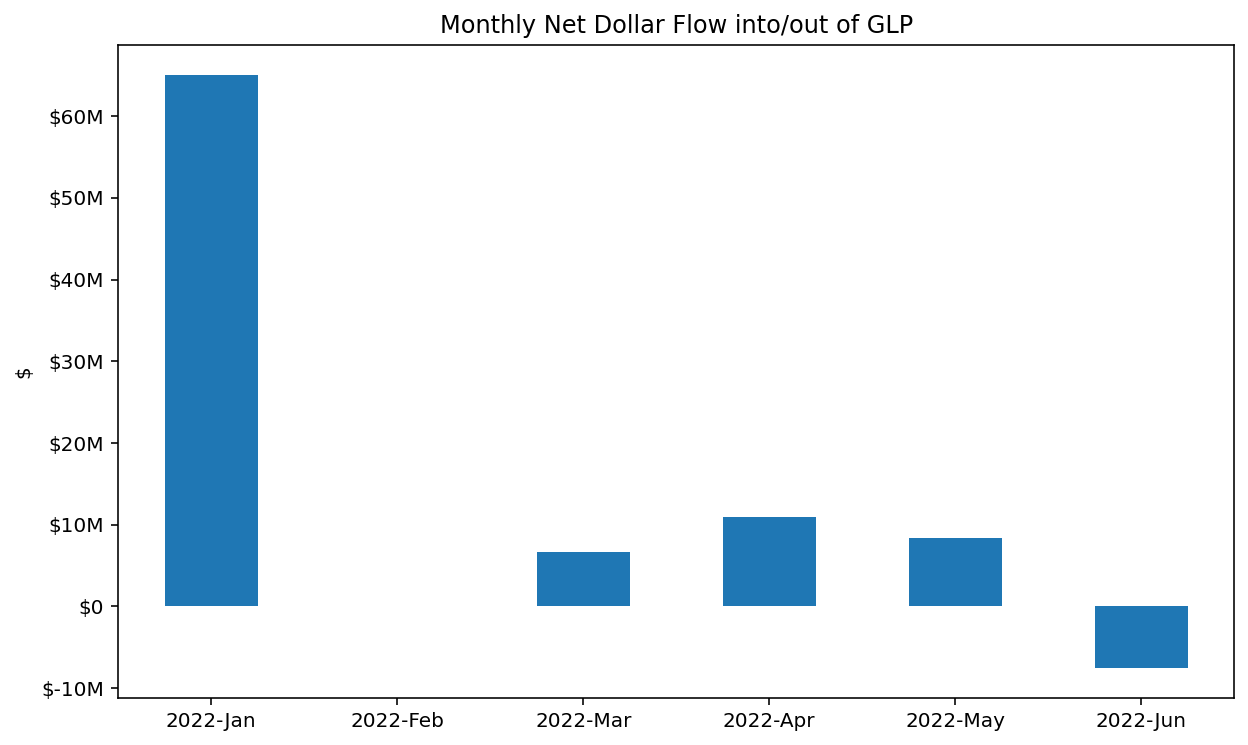

In [12]:
ax = monthly_ndf.plot(kind='bar',
                      title="Monthly Net Dollar Flow into/out of GLP",
                      ylabel='$', xlabel='', rot=0)
ax.set_xticklabels(monthly_ndf.index.to_timestamp().strftime('%Y-%b'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'monthly_ndf.png'), dpi=300);

- In January 2022, the first month GMX opened on Avalanche, more than `$65M` (net) flew into GLP.
- The net dollar flow was much less for the following months, with the best being `~$11M`.
- In June 2022, `~$7M` (net) left GLP as we entered the crypto bear market.

### Weekly

In [13]:
weekly_ndf = daily_flow.groupby(daily_flow.index.to_period('W')).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2022-01-03/2022-01-09    8,884,255.9281
2022-01-10/2022-01-16   22,982,531.9584
2022-01-17/2022-01-23    8,874,382.9356
2022-01-24/2022-01-30   22,429,401.3965
2022-01-31/2022-02-06    5,919,215.2339
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

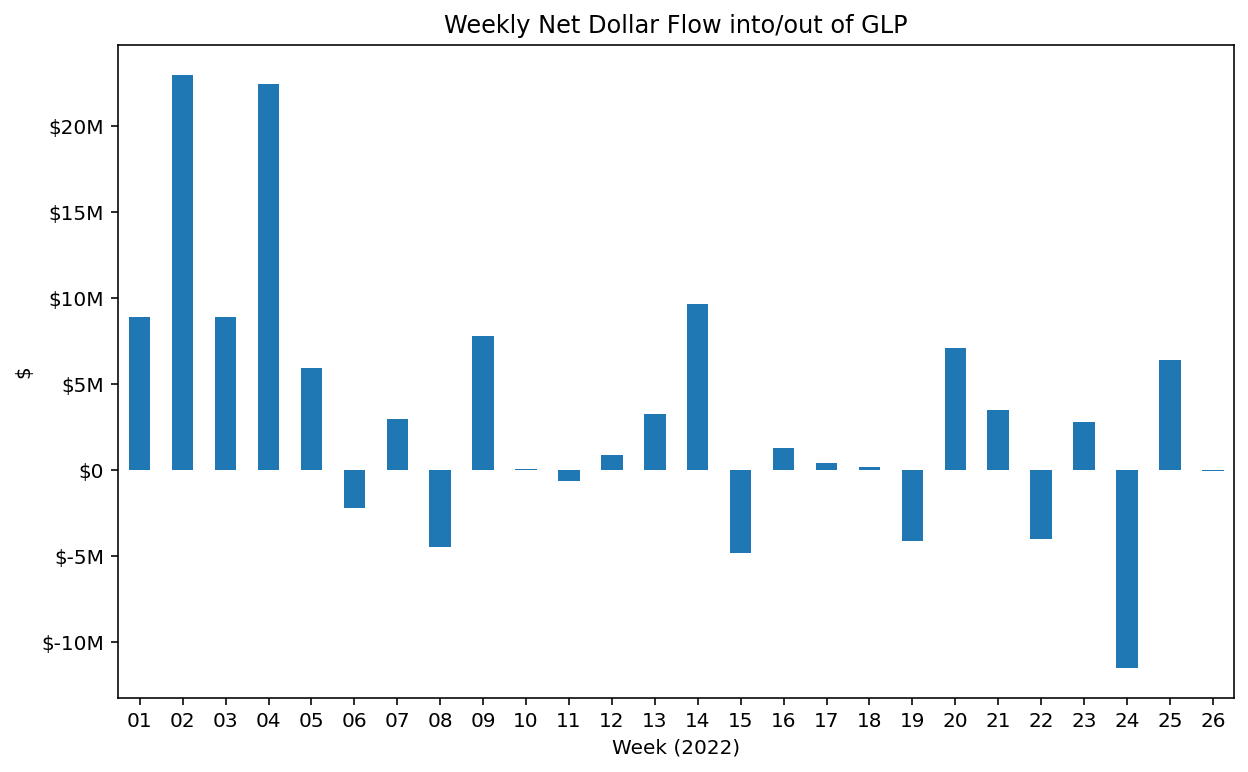

In [14]:
ax = weekly_ndf.plot(kind='bar', title="Weekly Net Dollar Flow into/out of GLP",
                      ylabel='$', xlabel='Week (2022)', rot=0)
ax.set_xticklabels(weekly_ndf.index.to_timestamp().strftime('%W'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf.png'), dpi=300);

### Weekly - Investigate linear trend

Let's remove January data and look at the remaining data week by week.

In [15]:
# drop January data
daily_flow_since_feb = daily_flow[daily_flow.index.month != 1]
daily_flow_since_feb.head()

,aum,glpSupply,glpPrice,net_dollar_flow
Date,,,,
2022-02-01,"4,873,291.0860","3,417,685.0595",1.0769,"3,680,607.3710"
2022-02-02,"-11,267,799.4703","-9,024,353.4150",1.0531,"-9,503,493.7903"
2022-02-03,"-1,051,657.4946","-849,057.2359",1.0506,"-892,052.2112"
2022-02-04,"11,113,923.1046","5,876,465.7178",1.1212,"6,588,610.0656"
2022-02-05,"3,432,663.5758","2,731,193.6841",1.1263,"3,076,083.9146"


In [16]:
weekly_ndf = daily_flow_since_feb.groupby(daily_flow_since_feb.index.to_period('W')).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2022-01-31/2022-02-06    4,042,686.5234
2022-02-07/2022-02-13   -2,185,817.8526
2022-02-14/2022-02-20    2,957,612.2324
2022-02-21/2022-02-27   -4,493,223.5019
2022-02-28/2022-03-06    7,797,674.9050
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

In [17]:
# make linear trend features for weekly level
X_weekly = weekly_ndf.index.values.reshape(-1,1)
# rescale to 1 to nweeks so that the slope of the fitted line measures the unit change per week
X_weekly = (np.array(range(len(X_weekly))) + 1).reshape(-1,1) 
X_weekly.shape

(22, 1)

In [18]:
# fit linear trend line
y = weekly_ndf
dd = fit_linreg(X_weekly, y) # returns a dictionary
yhat = dd['yhat']
slope = dd['slope']

intercept: 1997532.212524664 slope: -100702.57599757334


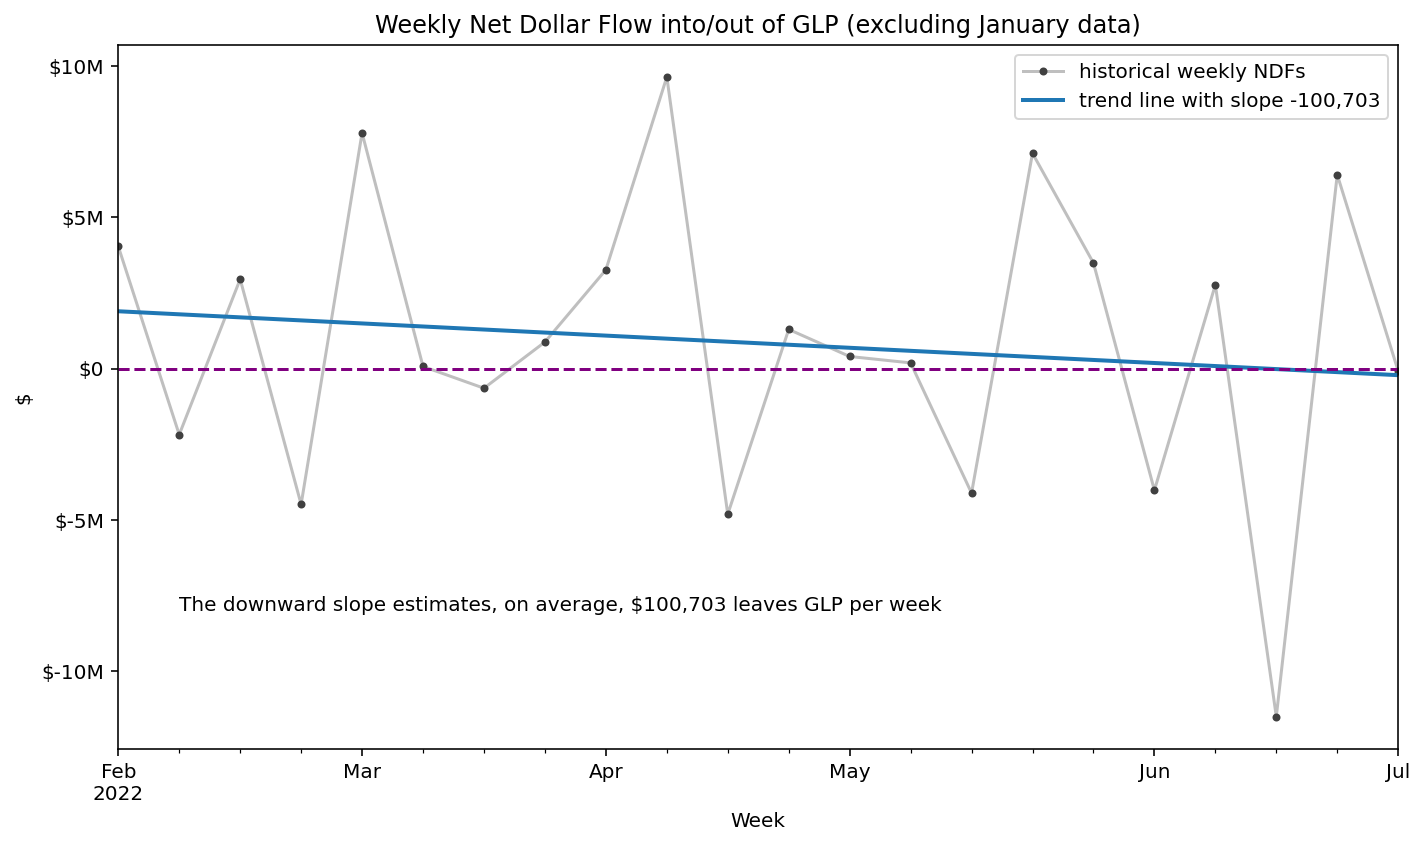

In [19]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Net Dollar Flow into/out of GLP (excluding January data)', ylabel='$', 
    ytru_legend='historical weekly NDFs', 
    yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.axhline(0.5, linestyle='--', color='purple')
ax.text('2022-02-11', -8e6, "The downward slope estimates, on average, ${:,.0f} leaves GLP per week".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf_trend.png'), dpi=300);